In [1]:
import (
	"encoding/csv"
	"image/color"
	"log"
	"math"
	"os"
	"strconv"

    "gonum.org/v1/plot"
    "gonum.org/v1/plot/plotter"
    "gonum.org/v1/plot/vg"
    "github.com/go-gota/gota/dataframe"
)

In [2]:
func displayPlot(p *plot.Plot) {
    var buf bytes.Buffer
    c, err := p.WriterTo(10*vg.Inch, 4*vg.Inch, "png")
    if err != nil {
        panic(err)
    }
    
    if _, err := c.WriteTo(&buf); err != nil {
        panic(err)
    }

    gonbui.DisplayPNG(buf.Bytes())
}

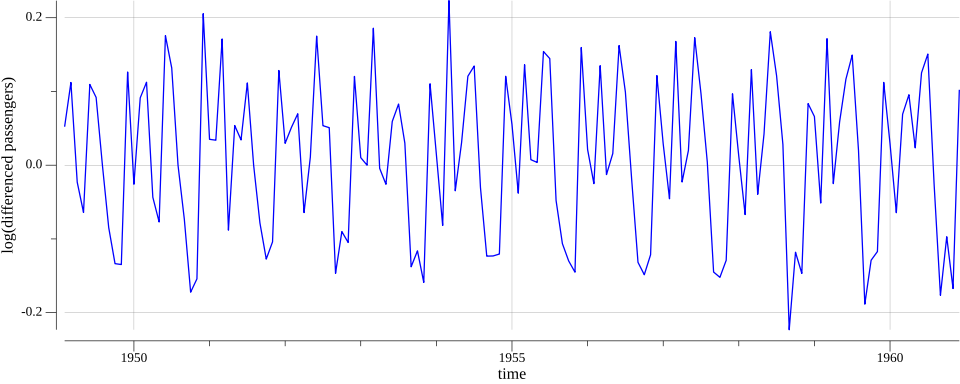

In [3]:
func main() {

	// Open the CSV file.
	passengersFile, err := os.Open("AirPassengers.csv")
	if err != nil {
		log.Fatal(err)
	}
	defer passengersFile.Close()

	// Create a dataframe from the CSV file.
	passengersDF := dataframe.ReadCSV(passengersFile)

	// Extract the number of passengers and time columns
	// as slices of floats.
	passengerVals := passengersDF.Col("AirPassengers").Float()
	timeVals := passengersDF.Col("time").Float()

	// pts will hold the values for plotting.
	pts := make(plotter.XYs, passengersDF.Nrow()-1)

	// differenced will hold our differenced values
	// that will be output to a new CSV file.
	var differenced [][]string
	differenced = append(differenced, []string{"time", "log_differenced_passengers"})

	// Fill pts with data.
	for i := 1; i < len(passengerVals); i++ {
		pts[i-1].X = timeVals[i]
		pts[i-1].Y = math.Log(passengerVals[i]) - math.Log(passengerVals[i-1])
		differenced = append(differenced, []string{
			strconv.FormatFloat(timeVals[i], 'f', -1, 64),
			strconv.FormatFloat(math.Log(passengerVals[i])-math.Log(passengerVals[i-1]), 'f', -1, 64),
		})
	}

	// Create the plot.
	p := plot.New()
	p.X.Label.Text = "time"
	p.Y.Label.Text = "log(differenced passengers)"
	p.Add(plotter.NewGrid())

	// Add the line plot points for the time series.
	l, err := plotter.NewLine(pts)
	if err != nil {
		log.Fatal(err)
	}
	l.LineStyle.Width = vg.Points(1)
	l.LineStyle.Color = color.RGBA{B: 255, A: 255}

	// Save the plot to a PNG file.
	p.Add(l)
	
    displayPlot(p)

	// Save the differenced data out to a new CSV.
	f, err := os.Create("log_diff_series.csv")
	if err != nil {
		log.Fatal(err)
	}
	defer f.Close()

	w := csv.NewWriter(f)
	w.WriteAll(differenced)

	if err := w.Error(); err != nil {
		log.Fatal(err)
	}
}